In [1]:
import math

import scipy
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__


'0.10'

In [2]:
def create_pdf_network():
    graph = nx.Graph()
    graph.add_edge(1, 4, weight=1)
    graph.add_edge(1, 2, weight=1)
    graph.add_edge(4, 2, weight=1)
    graph.add_edge(2, 3, weight=1)
    graph.add_edge(4, 3, weight=1)
    graph.add_edge(3, 6, weight=1)
    graph.add_edge(3, 7, weight=1)
    graph.add_edge(3, 5, weight=1)
    graph.add_edge(6, 7, weight=1)
    
    graph = graph.to_undirected()
    graph.remove_edges_from(graph.selfloop_edges())
    
    return graph



In [3]:
def average_degree(graph):
    degrees = graph.degree()
    return np.mean([*dict(degrees).values()])

In [4]:
def visualize(G, big=False, skip_weights=True):
    if big:
        plt.figure(figsize=(12, 8))
    labels = G.nodes()
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, with_labels=True, nodecolor='r', edge_color='b', 
            node_size=500, font_size=16, pos=pos, width=6)   # default spring_layout
    if skip_weights:
        new_labels = {(x,y): z for x, y, z in graph.edges(data=True)}
        nx.draw_networkx_edge_labels(G,pos, edge_labels=new_labels)
    else:
        nx.draw_networkx_edge_labels(G,pos)
    plt.show(True)

In [5]:
def visualize2(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
        
    labels = G.nodes()
    pos=nx.spring_layout(G)
    
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=700)

    # edges
    nx.draw_networkx_edges(G,pos,
                        width=6,alpha=0.5,edge_color='b',style='dashed')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

    plt.axis('off')
    plt.show() # display




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q1

## a) Degree distribution,

In [6]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues, Pk

In [7]:
graph = create_pdf_network()

In [8]:
def plot_degree_dist(graph, use_log_scale=False, skip_plot=False, ks=None, Pk=None):
    # Calculate the data we want if the user doesn't give it to us
    if ks is None and Pk is None:
        ks, Pk = degree_distribution(graph)
        
    # In case we want only the degree distribution
    if not skip_plot:
        fig = plt.subplot(1,1,1)
        if use_log_scale:
            fig.set_xscale('log')
            fig.set_yscale('log')
        
        plt.plot(ks,Pk,'bo')
        plt.xlabel("k", fontsize=20)
        plt.ylabel("P(k)", fontsize=20)
        plt.title("Degree distribution", fontsize=20)
        #plt.grid(True)
        plt.show(True)
    return ks, Pk

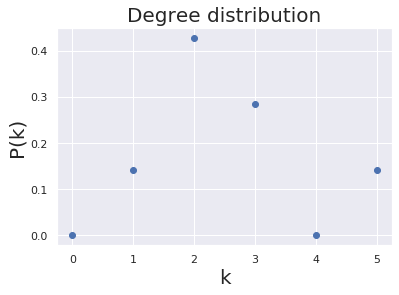

(array([0, 1, 2, 3, 4, 5]),
 array([0.        , 0.14285714, 0.42857143, 0.28571429, 0.        ,
        0.14285714]))

In [9]:
plot_degree_dist(graph)

## b) Local clustering coefficient

In [10]:
vcc = []
for i in graph.nodes():
    vcc.append(nx.clustering(graph, i))
vcc= np.array(vcc)
print('Clustering of all nodes:', vcc)

Clustering of all nodes: [1.         0.66666667 0.66666667 0.2        1.         1.
 0.        ]


## c) Transitivity

In [11]:
CC = (nx.transitivity(graph)) 
print("Transitivity = ","%3.4f"%CC)

Transitivity =  0.4737


## d) Distance matrix,

In [12]:
nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))

matrix([[0., 1., 2., 1., 3., 3., 3.],
        [1., 0., 1., 1., 2., 2., 2.],
        [2., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 2., 2., 2.],
        [3., 2., 1., 2., 0., 2., 2.],
        [3., 2., 1., 2., 2., 0., 1.],
        [3., 2., 1., 2., 2., 1., 0.]])

## e) Entropy of the degree distribution

In [13]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H



In [14]:
shannon_entropy(graph)

1.8423709931771088

## f) Second moment of the degree distribution.

In [15]:
def moment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M


In [16]:
k2 = moment_of_degree_distribution(graph, 2)
print("Second moment of the degree distribution = ", k2)

Second moment of the degree distribution =  8.0




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q2

In [17]:
def graph_to_undirected(graph, sum_edges=True, testing=False):   
    """Converts a graph to it's undirecte version. 
    If not sum_edges, we simply use the value of the 'last' edge when iterating.
    Otherwise, we sum the value of the incoming/outcoming edge.
    """
    if sum_edges:
        new_g = nx.Graph()
        new_g.add_edges_from(graph.edges, weight=0)
        for u, v in graph.edges:
            new_g[u][v]['weight'] += graph[u][v]['weight']
        new_g
    else:
        new_g = graph.to_undirected()

    # Quick test to show our implementation is correct
    if testing:
        graph = nx.DiGraph()
        graph.add_edge(2, 1, weight=1)
        graph.add_edge(1, 2, weight=2)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_undirected(graph))
    
    return new_g

def graph_to_unweighted(graph, min_weight=1, testing=False):
    """Converts a graph to it's unweighted version. 
    Any edge with weight >= min_weight is included.
    """
    Gnew = nx.Graph()
    for (u,v,w) in graph.edges(data=True):
        if w['weight'] >= min_weight :
            Gnew.add_edge(u, v)
    
    if testing:
        graph = nx.Graph()
        graph.add_edge(1, 2, weight=1)
        graph.add_edge(2, 3, weight=2)
        graph.add_edge(3, 4, weight=3)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_unweighted(graph, 3))

    return Gnew

    
def read_edges(filename, digraph=True):   
    """Reads an edge list dataset"""
    # Read the directed network

    graph = nx.read_weighted_edgelist(filename, nodetype=int,
                            create_using=nx.DiGraph) 
    return graph

Weighted Directed Lesmis: 


/home/gmelodie/Complex-Networks/complexn/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gmelodie/Complex-Networks/complexn/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


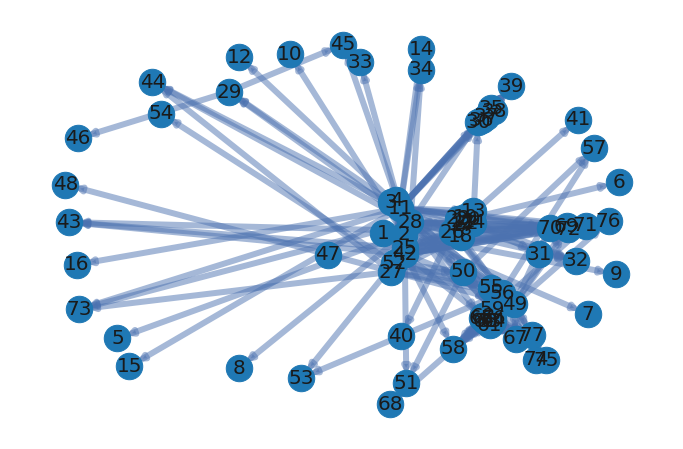

Unweighted Undirected Lesmis: 


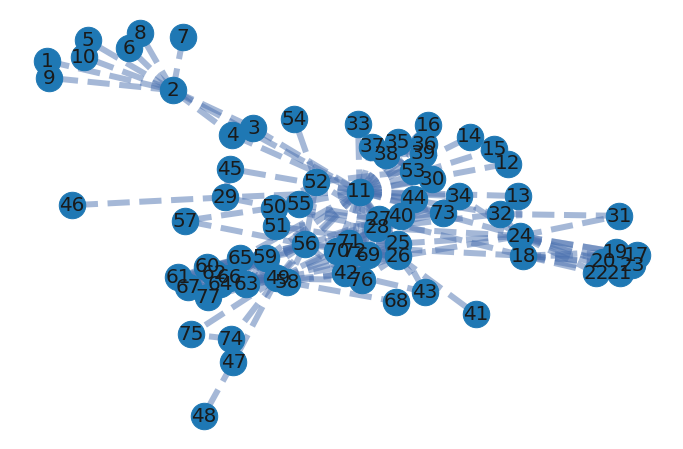

In [18]:
# Run Lesmis network
g_lesmis = read_edges("data/nets/lesmis.txt")
print("Weighted Directed Lesmis: ")
visualize2(g_lesmis, big=True)

print("Unweighted Undirected Lesmis: ")
g_lesmis = graph_to_undirected(g_lesmis, sum_edges=True)
visualize2(graph_to_unweighted(g_lesmis), big=True)

Weighted Directed Florida: 


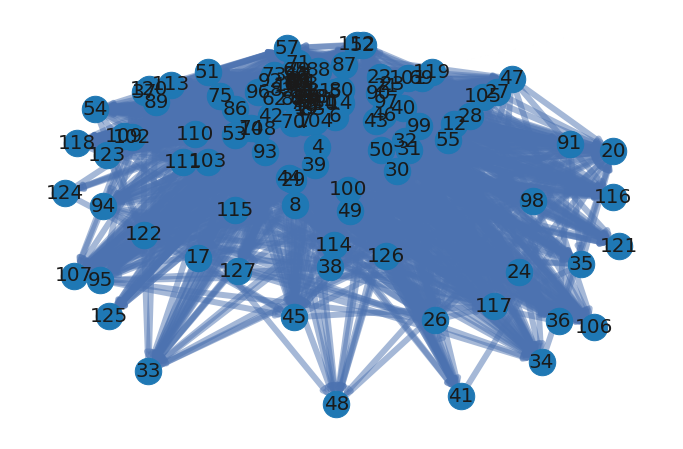

Unweighted Undirected Florida: 


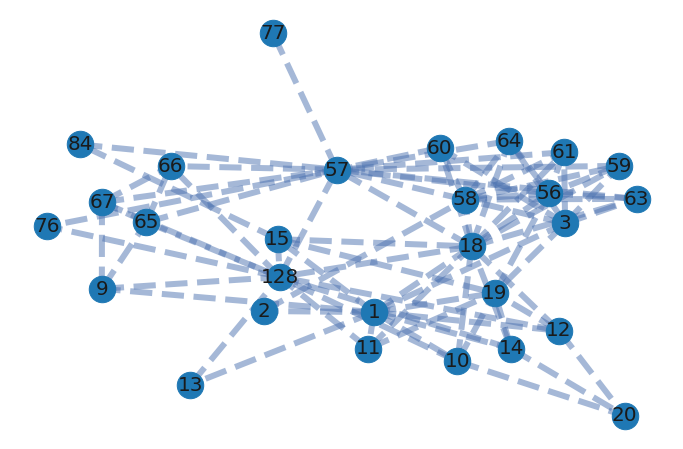

In [19]:
# Run Florida network
g_florida = read_edges("data/nets/eco-foodweb-baywet.edges")
print("Weighted Directed Florida: ")
visualize2(g_florida, big=True)
g_florida = graph_to_undirected(g_florida, sum_edges=True)
print("Unweighted Undirected Florida: ")
visualize2(graph_to_unweighted(g_florida), big=True)




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q3

In [20]:
# Read the data
G = read_edges("data/nets/lesmis.txt")
G = graph_to_undirected(G, sum_edges=True)
G = graph_to_unweighted(G)

In [21]:
# let networkx return the adjacency matrix A
A = nx.adj_matrix(G)
A = A.todense()
A = np.array(A, dtype = np.float64)

# define walk length and starting idx
# we start with a random point
walk_length = 100*len(G.nodes)
repetitions=10
visited = np.zeros(len(G.nodes))

for i in range(repetitions):
    # Use this to start with the node with the highest amount of neighbours
    #current = A.sum(axis=0).argmax()
    current = np.random.randint(len(G.nodes))
    for _ in range(walk_length):
        # Get the list of possible nodes at current step
        possible_nodes = np.flatnonzero(A[current])
        # Go the next node
        next_node = np.random.choice(possible_nodes)
        visited[next_node] += 1
        #visited.append(next_node)
        current = next_node

In [22]:
visited

array([ 161., 1748.,  480.,  502.,  179.,  189.,  179.,  174.,  168.,
        197., 5633.,  149.,  308.,  154.,  129.,  156., 2156., 1674.,
       2409., 1669., 2600.,  565., 1202.,  590.,  154.,  310.,  923.,
        958.,  899.,  939.,  913.,  486.,  314., 3209., 1073., 1007.,
       2900., 2280., 1911., 1560., 1622., 1532., 1445.,  490.,  281.,
        996., 1290., 1042.,  988.,  987.,  982.,  982., 1684.,  444.,
        290.,  468.,  145., 1005.,  566.,  141., 1676., 1618., 1402.,
       1658., 1979., 1819., 1870., 1509.,  242.,  239., 1118.,  233.,
        327.,  296.,  158.,  158.,  111.])

In [23]:
pearsonr(visited, A.sum(axis=0))

(0.9983082599291931, 2.0000116214982483e-94)

Sim, está altamente correlacionado!



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q4

## a)

In [24]:
graph = create_pdf_network()

In [25]:
def power_transition_matrix(G, power):
    transition_matrix = nx.google_matrix(G, alpha=1)
    return transition_matrix**power

In [26]:
power_transition_matrix(graph, 1000)

matrix([[0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556]])

Ele converge!

## b)

$$ ((Aij)^3, Dij) $$ for i, j= 1, . . . , N

In [27]:
def create_scatter_plot(power_matrix, dists, plot=True):
    x = []
    y = []
    for i in range(len(graph.nodes)):
        for j in range(len(graph.nodes)):
            x.append(power_matrix[i, j])
            y.append(dists[i, j])
    if plot:
        sns.scatterplot(x, y)
        plt.show()
    return x, y

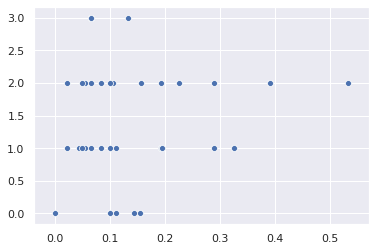

In [28]:
power_matrix = power_transition_matrix(graph, 3)
dists = nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))
create_scatter_plot(power_matrix, dists);

## c)

In [29]:
corrs = []
limit = 100

dists = nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))
for i in range(1, limit):
    power_matrix = power_transition_matrix(graph, i)
    x, y = create_scatter_plot(power_matrix, dists, plot=False);
    corrs.append(pearsonr(x, y)[0])

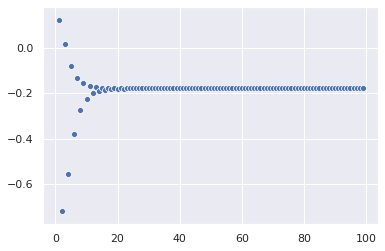

In [30]:
sns.scatterplot(list(range(1, limit)), corrs)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q5

$p_k  = \sum\limits_{q = k + 1}^\infty  {p_q } $

In [31]:
ks, Pk = plot_degree_dist(graph, skip_plot=True)
cumulative_Pk = np.cumsum(Pk)

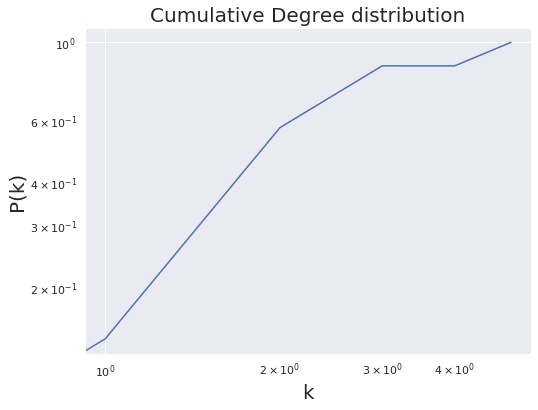

In [32]:
def plot_cumulative_degree_dist(ks, cumulative_Pk, use_log_scale=True,
                                title="Cumulative Degree distribution"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(ks, cumulative_Pk)
    
    if use_log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    plt.xlabel("k", fontsize=20)
    plt.ylabel("P(k)", fontsize=20)
    plt.title(title, fontsize=20)
    
    plt.show()
    
plot_cumulative_degree_dist(ks, cumulative_Pk)

How is the coefficient of this distribution related to the power law degree distribution?

Se tivermos uma rede que tenha uma power law degree distribution que segue uma exponencial ($ p_k  \sim k^{ - \gamma }$), então sua versão cumulativa definida como $p_k  = \sum\limits_{q = k + 1}^\infty  {p_q } $ irá seguir $p_k  \sim k^{ - \gamma  + 1} $,

Ou seja, quanto mais se aproximar de uma exponencial com um coefficiente alto, maior o efeito sobre o final da distribuição acumulativa



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q6

In [33]:
# Read all the data we will use now and in the future
all_graphs = {}
all_graphs["E-road"] = nx.read_edgelist("data/euroroad.txt")
all_graphs["Authors papers"] = nx.read_gml("data/netscience.gml")
all_graphs["Facebook"] = nx.read_edgelist("data/facebook_combined.txt")
all_graphs["Hamster"] = nx.read_edgelist("data/out.petster-friendships-hamster-uniq",
                                    comments="%")
all_graphs["Astro"] = nx.read_edgelist("data/out.ca-AstroPh",
                                    comments="%")

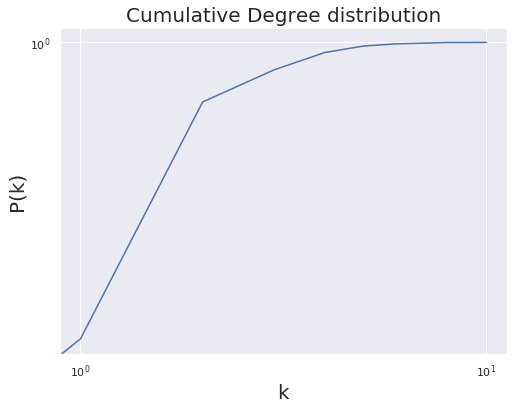

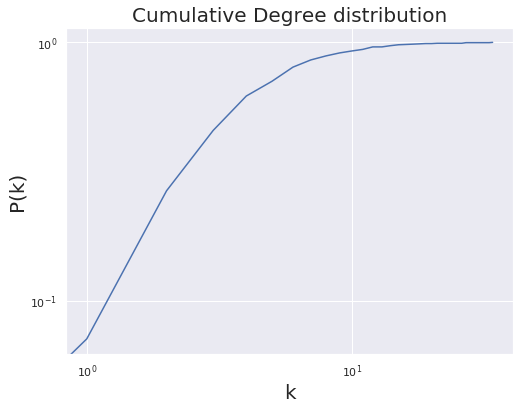

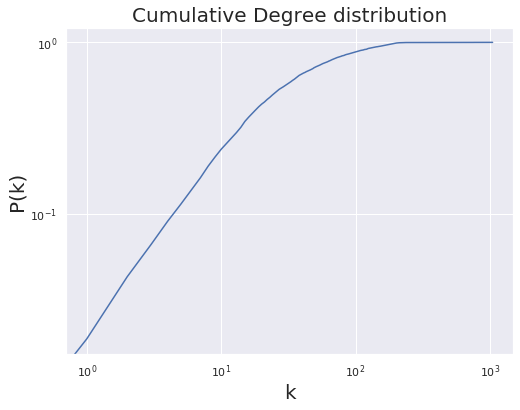

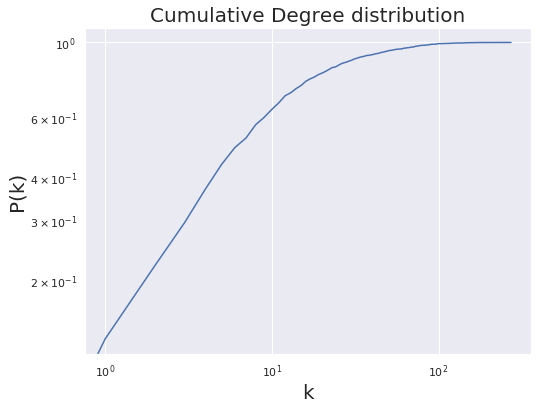

In [34]:
def get_biggest_component(graph, testing=False):
    """
    Fast function taken from:
        https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html
        
    If testing is True, use the smallest instead of the biggest connected component
    """
    
    if testing:
        return min(nx.connected_component_subgraphs(graph), key=len)
    else:
        return max(nx.connected_component_subgraphs(graph), key=len)

skip_graphs = ["Astro"]
for graph_name, graph in all_graphs.items():
    if graph_name in skip_graphs:
        continue
    biggest_connect_component = get_biggest_component(graph)
    ks, Pk = degree_distribution(biggest_connect_component)
    cumulative_Pk = np.cumsum(Pk)
    plot_cumulative_degree_dist(ks, cumulative_Pk, "CDF " + graph_name)

Comparando os resultados obtidos com os de uma rede que sabemos ser scale-free:

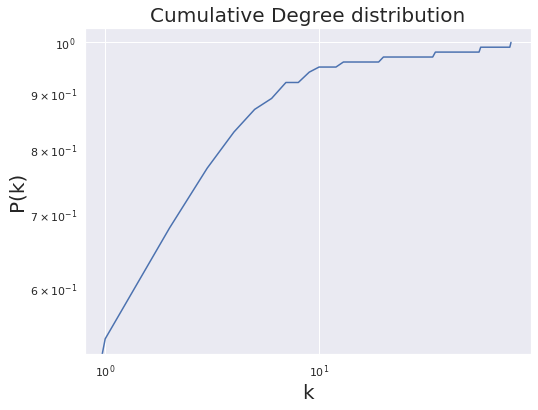

In [35]:
scale_free = graph_to_undirected(nx.scale_free_graph(100), sum_edges=False)
biggest_connect_component = get_biggest_component(scale_free)
ks, Pk = degree_distribution(biggest_connect_component)
cumulative_Pk = np.cumsum(Pk)
plot_cumulative_degree_dist(ks, cumulative_Pk, "CDF " + "scale free")

Então, percebemos que as redes acima, são de fato scale-free



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q7

In [36]:
# Define all the functions we wil use now and in the future
all_funcs = {
    "Num nodes": lambda x: len(x.nodes),
    "Avg degree": average_degree,
    "2nd Momentum": lambda x: moment_of_degree_distribution(x, 2),
    "Avg clust coef": nx.average_clustering,
    "Diameter": nx.diameter,
    "Avg shortest path": nx.average_shortest_path_length,
    "Transivity": nx.transitivity,
}

In [37]:
def run_experiment(use_funcs, skip_graphs, testing=False):
    """
    In case we are testing, use the smallest connected component instead
        of the biggest.
    """
    funcs = {x:y for x, y in all_funcs.items() if x in use_funcs}
    graphs = {x:y for x, y in all_graphs.items() if x not in skip_graphs}

    results = pd.DataFrame(columns=["Name"] + [*funcs.keys()])
    for graph_name, graph in graphs.items():
        connected_graph = get_biggest_component(graph, testing=testing)
        data = [graph_name]
        for name, func in funcs.items():
            data.append(func(connected_graph))
        results.loc[len(results)] = data
    
    return results

In [38]:
run_experiment(["Avg clust coef", "Transivity"], skip_graphs=["Authors papers"])

,Name,Avg clust coef,Transivity
0,E-road,0.018906,0.035255
1,Facebook,0.605547,0.519174
2,Hamster,0.143305,0.090369
3,Astro,0.632823,0.317778




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q8

In [39]:
def distribution_shortest_path(G, title="Distribution of the geodesic distances"):
    if nx.is_connected(G) == True:
        vl = []
        N = len(G.nodes)
        diam = nx.diameter(G)
        
        # Build matrix of distances (D)
        D = np.zeros(shape=(N, N))
        for i in np.arange(0,N):
            for j in np.arange(i+1, N):
                if(i != j):
                    aux = nx.shortest_path(G,i,j)
                    dij = len(aux)-1
                    D[i][j] = dij
                    D[j][i] = dij
                    vl.append(dij)
                    
        x = range(0,diam+1)
        plt.hist(vl, bins=x, normed=True)
        plt.ylabel("P(l)", fontsize=15)
        plt.xlabel("Shortest path length (l)", fontsize=15)
        plt.title(title, fontsize=20)
        plt.grid(True)
        plt.show(True)
    else:
        print("-"*10 + "ERROR!" + "-"*10)
        print("The graph has more than one connected component") 

/home/gmelodie/Complex-Networks/complexn/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


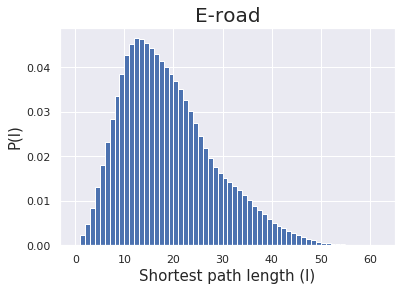

In [ ]:
graphs = {x:y for x, y in all_graphs.items() if x != "Authors papers"}

for graph_name, graph in graphs.items():
    connected_graph = get_biggest_component(graph)
    connected_graph = nx.convert_node_labels_to_integers(connected_graph)
    distribution_shortest_path(connected_graph, title=graph_name)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q9

(i) number of nodes, (ii) average degree, (iii) second moment of thedegree distribution, (iv) average clustering coefficient, (v) transitivity, (vi) average shortest pathlength, (vii) diameter

In [ ]:
use_funcs = {x:y for x, y in all_funcs.items() if x != "Transivity"}
run_experiment(use_funcs, ["Authors Papers"])



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q10

In [ ]:
def complexity(G):
    k2 = momment_of_degree_distribution(G,2)
    k1 = momment_of_degree_distribution(G,1)
    return round((k2/k1), 3)

### Londrina (PR)

In [ ]:
londrina = ox.graph_from_place('Londrina', network_type='drive', simplify=False)
print('Complexity: ', end='')
print(complexity(londrina))
print('Average shortest path length: ', end='')
print(nx.average_shortest_path_length(londrina))
print('Average clustering coefficient:')
print(nx.average_clustering(londrina))

### Araraquara (PR)

In [ ]:
araraquara = ox.graph_from_place('Araraquara', network_type='drive', simplify=False)
print('Complexity: ', end='')
print(complexity(araraquara))
print('Average shortest path length: ', end='')
print(nx.average_shortest_path_length(araraquara))
print('Average clustering coefficient:')
print(nx.average_clustering(araraquara))

### Taquaritinga (PR)

In [ ]:
taquaritinga = ox.graph_from_place('Taquaritinga', network_type='drive', simplify=False)
print('Complexity: ', end='')
print(complexity(taquaritinga))
print('Average shortest path length: ', end='')
print(nx.average_shortest_path_length(taquaritinga))
print('Average clustering coefficient:')
print(nx.average_clustering(taquaritinga))